In [1]:
from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import importlib
import mlflow as ml
import json

import utillities as ut
import surv_bart as bmb


In [205]:
# Required input
EXP_ID = "553714660218339146"
TRAIN_RUN_ID = "c203024be50a4831875b482940ecdf9a"
SUB_RUN_NAME = "r2_sub1"

In [210]:
# ml_exp = ml.get_experiment_by_name(EXP_NAME)
ml_exp = ml.get_experiment(EXP_ID)
ml_exp = ml.set_experiment("br1")
# start the training run
train_run = ml.start_run(TRAIN_RUN_ID)

# client = ml.tracking.MlflowClient()
# client.list_artifacts(train_run.info.run_id)

# get model parameters
art_pth = train_run.info.artifact_uri
param_pth = ml.artifacts.download_artifacts(artifact_uri=art_pth + "/parameter_dict.json")
with open(param_pth, "rb") as f:
    params = json.load(f)
model_dict = params["model_dict"]

# get paths for idata and tree
idata_path = ml.artifacts.download_artifacts(artifact_uri=train_run.info.artifact_uri + "/test_idata1.pkl")
tree_path = ml.artifacts.download_artifacts(artifact_uri=train_run.info.artifact_uri + "/test_tree1.pkl")


In [86]:
# if run_id:
    # run_id = ml.search_runs(ml_exp.experiment_id,output_format="list")[2].info.run_id
# train_run.data.params

# client.list_artifacts(train_run.info.run_id)

# PDP Evaluations

In [211]:
# start the sub run for a specific trained model
sub_run2 = ml.start_run(run_name=SUB_RUN_NAME, nested=True)

In [212]:
# build the new model
bart_m2 = bmb.BartSurvModel(model_config=model_dict).load(idata_path, tree_path)

PDP on virst VAR compare to EXP

In [248]:
x2 = bart_m2.X[bart_m2.X[:,0]==1][:,1:]
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [0], values = [[0,1]], sample_n=5000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)

In [249]:
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

In [250]:
sv = bmb.get_survival(pdp_post, mean=False)

In [236]:
# sv2 = (sv[:,6000:] - sv[:,0:6000] ).mean(0)
# sv3 = sv2.reshape(-1,6)
# sv3m = sv3.mean(0)
# sv3q = np.quantile(sv3, [0.0275, 0.975], axis = 0)
# sv3q2 = sv3q - sv3m

In [244]:
# sv2 = np.quantile((sv[:,6000:] - sv[:,0:6000] ), [0.025, 0.975], axis=0)
# sv2[0,:].reshape(-1,6).mean()
# sv2[1,:].reshape(-1,6).mean()
# sv3 = sv2.reshape(-1,6)
# sv3m = sv3.mean(0)
# sv3q = np.quantile(sv3, [0.0275, 0.975], axis = 0)
# sv3q2 = sv3q - sv3m

0.003628929223246772

In [251]:
# ALPHA_F = train_run.data.params[]
ALPHA_F = train_run.data.params["ALPHA"]
LAMBDA = train_run.data.params["LAMBDA"]
eos = int(train_run.data.params["EOS"])
time_scale = int(train_run.data.params["TIME_SCALE"])

In [252]:
pdp_scale = ut.sim_surv(pdp_sk, LAMBDA, ALPHA_F, eos, time_scale=time_scale, return_full=False, true_only=True)

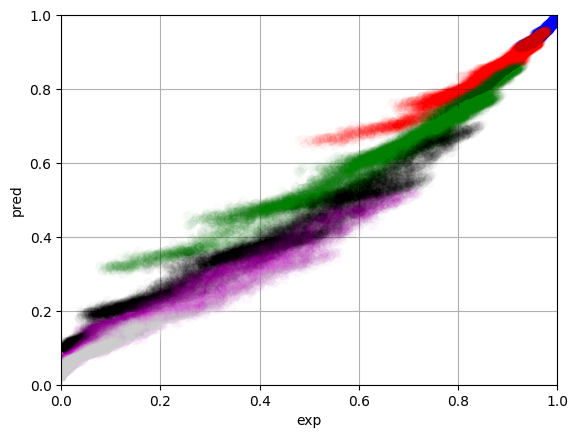

In [253]:
# true plot
fig, ax = plt.subplots(1)

ax.plot(pdp_scale["sv_true"][:,1], pdp_sv[:,0], "bo", alpha=0.02)
ax.plot(pdp_scale["sv_true"][:,2], pdp_sv[:,1], "ro", alpha=0.02)
ax.plot(pdp_scale["sv_true"][:,3], pdp_sv[:,2], "go", alpha=0.02)
ax.plot(pdp_scale["sv_true"][:,4], pdp_sv[:,3], "ko", alpha=0.02)
ax.plot(pdp_scale["sv_true"][:,5], pdp_sv[:,4], "mo", alpha=0.02)
ax.plot(pdp_scale["sv_true"][:,6], pdp_sv[:,5], "wo", alpha=0.02)

ax.grid(visible=True)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_ylabel("pred")
ax.set_xlabel("exp")

ml.log_figure(fig, "Exp_Pred_PDP_compare_var_0.png")

Plot the pdp comparison of expected pdp and predicted pdp.

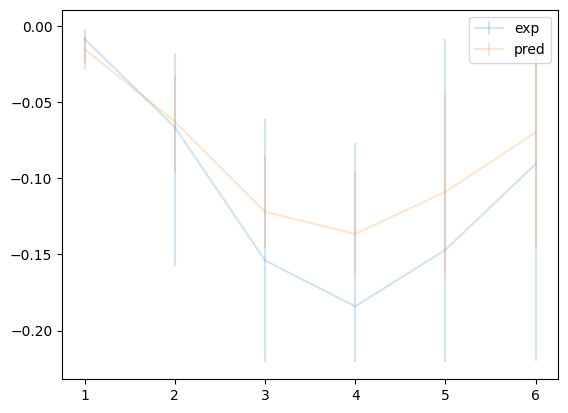

In [255]:
exp0 = pdp_scale["sv_true"][pdp_idx["coord"]==0]
exp1 = pdp_scale["sv_true"][pdp_idx["coord"]==1]
edm = (exp1-exp0).mean(0)
edq = edm - np.quantile((exp1-exp0), [0.025, 0.975], axis=0)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

fig, ax = plt.subplots(1)
ax.errorbar([1,2,3,4,5,6], y = edm[1:], yerr = np.abs(edq[:,1:]), alpha=0.2, label = "exp")
ax.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")


ax.legend()

ml.log_figure(fig, "Difference VAR0=1 - Difference VAR0=0.png")

## General PDP

[1.66883725 1.51603536 1.41336708 1.31435314 1.26210229 1.22362564]
[[1.54759131 1.40085599 1.28615797 1.2001742  1.16094926 1.13368075]
 [1.81431987 1.62910251 1.55368559 1.45517016 1.39029395 1.34195806]]
1.3997201256876728
[1.28823491 1.53075502]


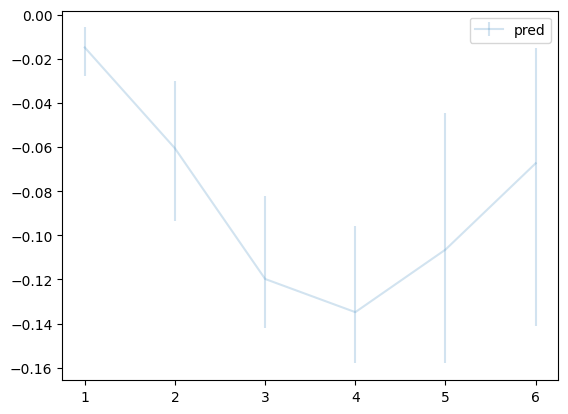

In [256]:
var_pdp = 0
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdci = np.quantile((pred1-pred0), [0.025, 0.975], axis=0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

fig, ax = plt.subplots(1)
ax.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
ax.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))


diff_dict = {
    "diff_mean_time": pdm.tolist(),
    "diff_ci_time": pdci.tolist()
}

rr_dict = {
    "rr_mean": rr_pred_m.tolist(),
    "rr_025": rr_pred_q[0].tolist(),
    "rr_975": rr_pred_q[1].tolist(),
    "rr_avg": rr_pred_m.mean().tolist(),
    "rr_avg_ci": [rr_pred_q[0].mean().tolist(), rr_pred_q[1].mean().tolist()]
}


b_title = f"Var {var_pdp}: Values {v2q} PDP "
ml.log_figure(fig, b_title + "diff plot.png")
ml.log_dict(diff_dict, b_title + "diff dict.json")
ml.log_dict(rr_dict, b_title + "rr dict.json")

[1.03527668 1.01771482 1.00216792 1.00466162 1.00636745 1.00539035]
[[1.01307621 1.00537769 0.99563641 1.00009242 1.00251144 1.0019574 ]
 [1.0547924  1.02831613 1.00599571 1.00847944 1.01117987 1.00946677]]
1.011929809025333
[1.00310859 1.01970505]


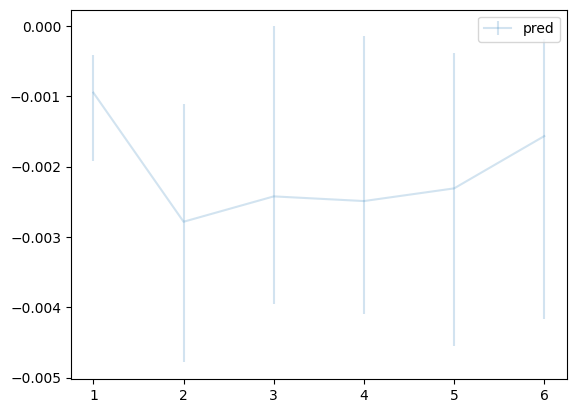

In [257]:
var_pdp = 1
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)




rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

fig, ax = plt.subplots(1)
ax.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
ax.legend()

diff_dict = {
    "diff_mean_time": pdm.tolist(),
    "diff_ci_time": pdci.tolist()
}

rr_dict = {
    "rr_mean": rr_pred_m.tolist(),
    "rr_025": rr_pred_q[0].tolist(),
    "rr_975": rr_pred_q[1].tolist(),
    "rr_avg": rr_pred_m.mean().tolist(),
    "rr_avg_ci": [rr_pred_q[0].mean().tolist(), rr_pred_q[1].mean().tolist()]
}


b_title = f"Var {var_pdp}: Values {v2q} PDP "
ml.log_figure(fig, b_title + "diff plot.png")
ml.log_dict(diff_dict, b_title + "diff dict.json")
ml.log_dict(rr_dict, b_title + "rr dict.json")

[2.12833349 1.94466373 1.69609175 1.49015147 1.37294612 1.29624407]
[[1.93326526 1.75812492 1.51962395 1.34283204 1.25570746 1.19928821]
 [2.28430508 2.1461669  1.88846545 1.66013329 1.50563793 1.40830898]]
1.654738437571362
[1.50147364 1.81550294]


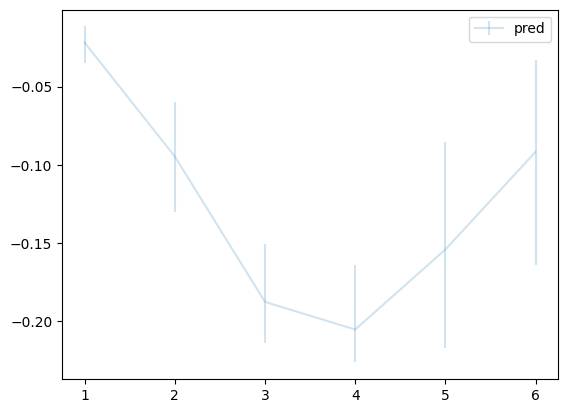

In [258]:
var_pdp = 2
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

# plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
# plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

fig, ax = plt.subplots(1)
ax.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
ax.legend()

diff_dict = {
    "diff_mean_time": pdm.tolist(),
    "diff_ci_time": pdci.tolist()
}

rr_dict = {
    "rr_mean": rr_pred_m.tolist(),
    "rr_025": rr_pred_q[0].tolist(),
    "rr_975": rr_pred_q[1].tolist(),
    "rr_avg": rr_pred_m.mean().tolist(),
    "rr_avg_ci": [rr_pred_q[0].mean().tolist(), rr_pred_q[1].mean().tolist()]
}


b_title = f"Var {var_pdp}: Values {v2q} PDP "
ml.log_figure(fig, b_title + "diff plot.png")
ml.log_dict(diff_dict, b_title + "diff dict.json")
ml.log_dict(rr_dict, b_title + "rr dict.json")

[1.21675334 1.1318788  1.0922157  1.06060573 1.04686167 1.0327659 ]
[[1.16305659 1.08625318 1.05454692 1.03169475 1.02313873 1.01547197]
 [1.27321189 1.17774463 1.12511806 1.0885171  1.07051153 1.05038049]]
1.0968468562378828
[1.06236036 1.13091395]


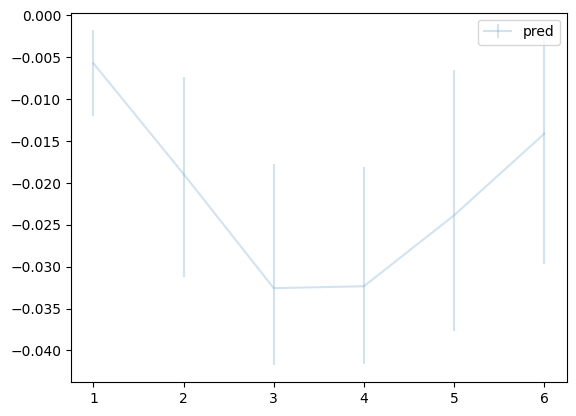

In [259]:
var_pdp = 3
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

# plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
# plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

fig, ax = plt.subplots(1)
ax.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
ax.legend()

diff_dict = {
    "diff_mean_time": pdm.tolist(),
    "diff_ci_time": pdci.tolist()
}

rr_dict = {
    "rr_mean": rr_pred_m.tolist(),
    "rr_025": rr_pred_q[0].tolist(),
    "rr_975": rr_pred_q[1].tolist(),
    "rr_avg": rr_pred_m.mean().tolist(),
    "rr_avg_ci": [rr_pred_q[0].mean().tolist(), rr_pred_q[1].mean().tolist()]
}


b_title = f"Var {var_pdp}: Values {v2q} PDP "
ml.log_figure(fig, b_title + "diff plot.png")
ml.log_dict(diff_dict, b_title + "diff dict.json")
ml.log_dict(rr_dict, b_title + "rr dict.json")

[1.62050686 1.5655282  1.42606685 1.32011981 1.25723125 1.2269655 ]
[[1.47138737 1.39531128 1.2665305  1.18446728 1.14256382 1.12365926]
 [1.77910313 1.73031577 1.58970303 1.47286966 1.39019392 1.35043119]]
1.4027364111751852
[1.26398659 1.55210278]


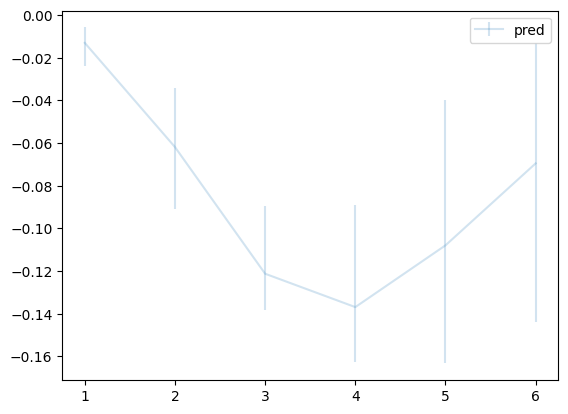

In [260]:
var_pdp = 4
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

# plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
# plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

fig, ax = plt.subplots(1)
ax.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
ax.legend()

diff_dict = {
    "diff_mean_time": pdm.tolist(),
    "diff_ci_time": pdci.tolist()
}

rr_dict = {
    "rr_mean": rr_pred_m.tolist(),
    "rr_025": rr_pred_q[0].tolist(),
    "rr_975": rr_pred_q[1].tolist(),
    "rr_avg": rr_pred_m.mean().tolist(),
    "rr_avg_ci": [rr_pred_q[0].mean().tolist(), rr_pred_q[1].mean().tolist()]
}


b_title = f"Var {var_pdp}: Values {v2q} PDP "
ml.log_figure(fig, b_title + "diff plot.png")
ml.log_dict(diff_dict, b_title + "diff dict.json")
ml.log_dict(rr_dict, b_title + "rr dict.json")

[1.02644787 1.00992501 1.00881269 1.00380107 1.00237575 1.00178199]
[[1.00603302 0.99556507 0.99899929 0.99488589 0.99428005 0.99554456]
 [1.04670604 1.02265634 1.01742209 1.01053242 1.0079309  1.00675202]]
1.0088573955761897
[0.99755131 1.01866664]


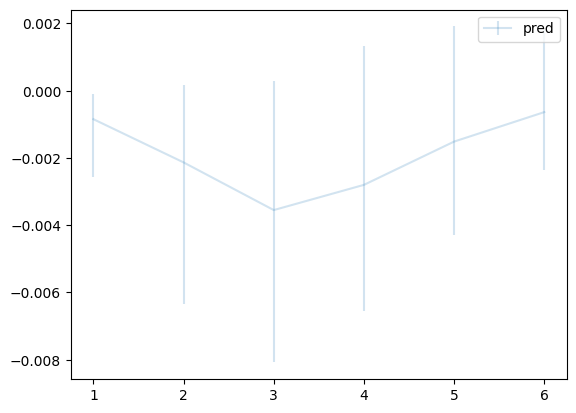

In [262]:
var_pdp = 5
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

# plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
# plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

fig, ax = plt.subplots(1)
ax.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
ax.legend()

diff_dict = {
    "diff_mean_time": pdm.tolist(),
    "diff_ci_time": pdci.tolist()
}

rr_dict = {
    "rr_mean": rr_pred_m.tolist(),
    "rr_025": rr_pred_q[0].tolist(),
    "rr_975": rr_pred_q[1].tolist(),
    "rr_avg": rr_pred_m.mean().tolist(),
    "rr_avg_ci": [rr_pred_q[0].mean().tolist(), rr_pred_q[1].mean().tolist()]
}


b_title = f"Var {var_pdp}: Values {v2q} PDP "
ml.log_figure(fig, b_title + "diff plot.png")
ml.log_dict(diff_dict, b_title + "diff dict.json")
ml.log_dict(rr_dict, b_title + "rr dict.json")

[0.98062144 0.97934942 0.99479653 0.99727024 0.99763703 0.99774124]
[[0.95032117 0.95921528 0.98168761 0.98704805 0.98908122 0.99018423]
 [1.00844832 0.99616663 1.00629899 1.00611366 1.0049247  1.00425793]]
0.9912359838363765
[0.97625626 1.00436837]


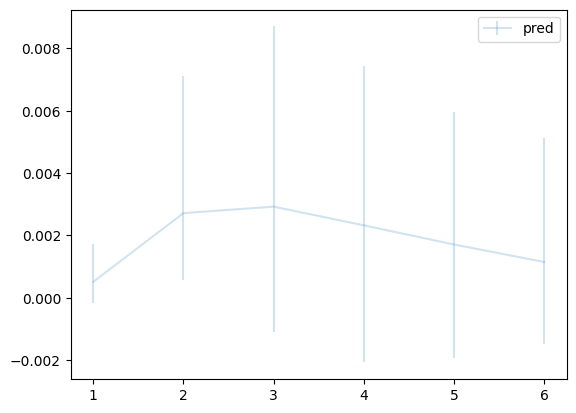

In [263]:
var_pdp = 6
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

# plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
# plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

fig, ax = plt.subplots(1)
ax.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
ax.legend()

diff_dict = {
    "diff_mean_time": pdm.tolist(),
    "diff_ci_time": pdci.tolist()
}

rr_dict = {
    "rr_mean": rr_pred_m.tolist(),
    "rr_025": rr_pred_q[0].tolist(),
    "rr_975": rr_pred_q[1].tolist(),
    "rr_avg": rr_pred_m.mean().tolist(),
    "rr_avg_ci": [rr_pred_q[0].mean().tolist(), rr_pred_q[1].mean().tolist()]
}


b_title = f"Var {var_pdp}: Values {v2q} PDP "
ml.log_figure(fig, b_title + "diff plot.png")
ml.log_dict(diff_dict, b_title + "diff dict.json")
ml.log_dict(rr_dict, b_title + "rr dict.json")

[1.00120822 1.00173453 1.0027555  1.00151932 0.99848961 0.99872739]
[[0.99745108 0.99926844 1.00123493 1.00050716 0.99666831 0.99707301]
 [1.01134618 1.00850268 1.00691639 1.00460791 1.0009391  1.00082684]]
1.000739095257449
[0.99870049 1.00552318]


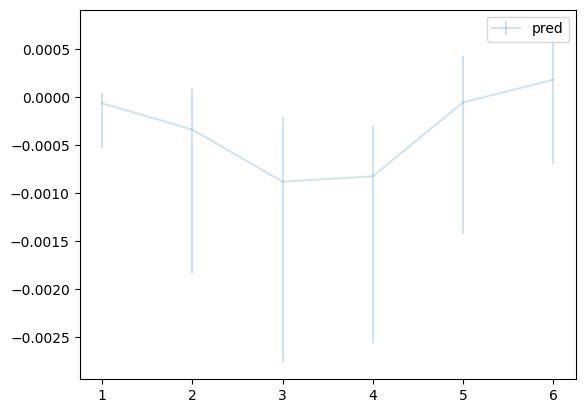

In [264]:
var_pdp = 7
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

# plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
# plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

fig, ax = plt.subplots(1)
ax.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
ax.legend()

diff_dict = {
    "diff_mean_time": pdm.tolist(),
    "diff_ci_time": pdci.tolist()
}

rr_dict = {
    "rr_mean": rr_pred_m.tolist(),
    "rr_025": rr_pred_q[0].tolist(),
    "rr_975": rr_pred_q[1].tolist(),
    "rr_avg": rr_pred_m.mean().tolist(),
    "rr_avg_ci": [rr_pred_q[0].mean().tolist(), rr_pred_q[1].mean().tolist()]
}


b_title = f"Var {var_pdp}: Values {v2q} PDP "
ml.log_figure(fig, b_title + "diff plot.png")
ml.log_dict(diff_dict, b_title + "diff dict.json")
ml.log_dict(rr_dict, b_title + "rr dict.json")

[1.02695744 1.00637094 1.00396404 1.00194697 1.00155606 1.00115029]
[[1.00913068 0.99536047 0.99495958 0.99496604 0.99544291 0.99614417]
 [1.05317915 1.01707178 1.01197827 1.00817687 1.00662307 1.00563138]]
1.0069909569603073
[0.99766731 1.01711009]


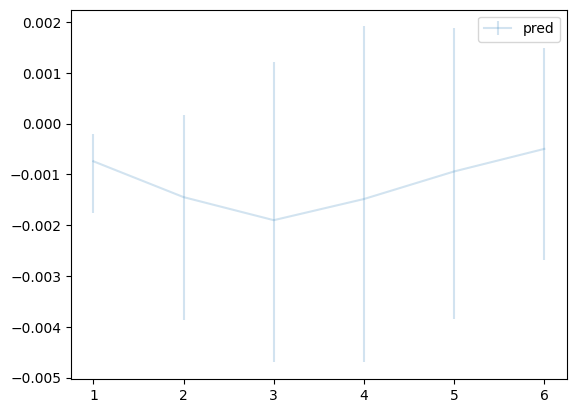

In [265]:
var_pdp = 8
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

# plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
# plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

fig, ax = plt.subplots(1)
ax.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
ax.legend()

diff_dict = {
    "diff_mean_time": pdm.tolist(),
    "diff_ci_time": pdci.tolist()
}

rr_dict = {
    "rr_mean": rr_pred_m.tolist(),
    "rr_025": rr_pred_q[0].tolist(),
    "rr_975": rr_pred_q[1].tolist(),
    "rr_avg": rr_pred_m.mean().tolist(),
    "rr_avg_ci": [rr_pred_q[0].mean().tolist(), rr_pred_q[1].mean().tolist()]
}


b_title = f"Var {var_pdp}: Values {v2q} PDP "
ml.log_figure(fig, b_title + "diff plot.png")
ml.log_dict(diff_dict, b_title + "diff dict.json")
ml.log_dict(rr_dict, b_title + "rr dict.json")

[1.03623671 1.02715219 1.00311479 1.00172082 1.00376529 1.00321081]
[[0.99199195 1.00683345 0.98478397 0.9864229  0.99143589 0.99258191]
 [1.07367011 1.0445693  1.01210459 1.00862877 1.00973497 1.00844911]]
1.0125334346931798
[0.99234168 1.02619281]


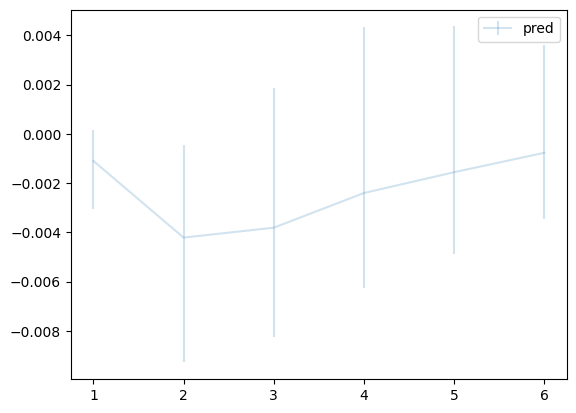

In [266]:
var_pdp = 9
v2q = np.quantile(x2[:,var_pdp], [0.25,0.75])
pdp_sk, pdp_idx = bmb.get_pdp(x2, var_col = [var_pdp], values = [v2q], sample_n=1000)
pdp_x, pdp_coords = bmb.get_posterior_test(bart_m2.uniq_times, pdp_sk)
pdp_post = bart_m2.bart_predict(pdp_x, pdp_coords)
pdp_sv = bmb.get_survival(pdp_post)
pdp_prob = bmb.get_prob(pdp_post)

pred0 = pdp_sv[pdp_idx["coord"]==0]
pred1 = pdp_sv[pdp_idx["coord"]==1]
pdm = (pred1-pred0).mean(0)
pdq = pdm - np.quantile((pred1-pred0), [0.025, 0.975], axis=0)

# plt.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
# plt.legend()

rr_pred = (pdp_prob[pdp_idx["coord"]==1]/pdp_prob[pdp_idx["coord"]==0])
rr_pred_m = rr_pred.mean(0)
rr_pred_q = np.quantile(rr_pred, [0.025,0.975], 0)

print(rr_pred_m)
print(rr_pred_q)
print(rr_pred_m.mean())
print(rr_pred_q.mean(1))

fig, ax = plt.subplots(1)
ax.errorbar([1,2,3,4,5,6], y = pdm, yerr = np.abs(pdq), alpha=0.2, label = "pred")
ax.legend()

diff_dict = {
    "diff_mean_time": pdm.tolist(),
    "diff_ci_time": pdci.tolist()
}

rr_dict = {
    "rr_mean": rr_pred_m.tolist(),
    "rr_025": rr_pred_q[0].tolist(),
    "rr_975": rr_pred_q[1].tolist(),
    "rr_avg": rr_pred_m.mean().tolist(),
    "rr_avg_ci": [rr_pred_q[0].mean().tolist(), rr_pred_q[1].mean().tolist()]
}


b_title = f"Var {var_pdp}: Values {v2q} PDP "
ml.log_figure(fig, b_title + "diff plot.png")
ml.log_dict(diff_dict, b_title + "diff dict.json")
ml.log_dict(rr_dict, b_title + "rr dict.json")

Comparisons of the estimated Risk Ratio can be compared to CPH HR that are listed below.

In [267]:
ml.end_run()